In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


In [66]:
churn_prediction= pd.read_csv("C:/Users/kelfin.njagi/Documents/ML_Projects/Churn_prediction_System/Data/Churn_Modelling.csv",
                  index_col=[0],
                  parse_dates=[0])
churn_prediction.head()             

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


EDA & quick data cleaning


Quick overview (shape, types, top rows)

## DATA INSPECTION

In [67]:

df = churn_prediction.copy()
# quick checks
print("shape:", df.shape)
display(df.head())       # showing first rows
print("\ninfo:")
print(df.info())
print("\nsummary (numeric):")
display(df.describe().T)


shape: (10000, 13)


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



info:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB
None

summary (numeric):


,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
Exited,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


## Checking for Missing values & duplicates


In [68]:
print("Missing values per column:\n", df.isnull().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())


Missing values per column:
 CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Number of duplicate rows: 0


In [69]:
# --- Minimal, safe setup: drop IDs, split X/y, list dtypes & target balance ---
df = churn_prediction.copy()

# drop identifier columns (safe: errors='ignore' won't fail if missing)
df = df.drop(columns=['CustomerId', 'Surname'], errors='ignore')
if 'RowNumber' in df.columns:
    df = df.drop(columns=['RowNumber'], errors='ignore')

# define target and features
y = df['Exited']
X = df.drop(columns=['Exited'])

# quick checks to paste back here
print("X shape:", X.shape)
print("y value counts:\n", y.value_counts())
print("\ny proportions:\n", y.value_counts(normalize=True))

# list numeric vs categorical columns (we'll use this to decide scaling/encoding)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


X shape: (10000, 10)
y value counts:
 Exited
0    7963
1    2037
Name: count, dtype: int64

y proportions:
 Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Geography', 'Gender']


In [70]:

# Numeric and categorical columns 
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
            'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender']

# defining the transformers
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols), # scaling numeric features
                                               ('cat', OneHotEncoder(drop='first'), cat_cols)]) # one-hot encode categorical features)
#We drop the first column to avoid redundancy also known as multicollinearity
# Fitting and transforming the data
X_prepared = preprocessor.fit_transform(X)

print("Original X shape:", X.shape)
print("Transformed X shape:", X_prepared.shape)


Original X shape: (10000, 10)
Transformed X shape: (10000, 11)


In [71]:
X_encoded = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)


In [72]:

# Split data into train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3,       # 30% for testing
random_state=42,     # ensures reproducibility. You could use a different number too, just to fix it to that randomness
    stratify=y)          # keeps the same 0/1 ratio in train & test

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (7000, 11) (7000,)
Testing set shape: (3000, 11) (3000,)


<h2 style="color:green">Logistic Regression</h2>

In [73]:
# balance the classes
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

<h2 style="color:green">Confusion Matrix for linear regression</h2>

In [74]:

cm = confusion_matrix(y_test, y_pred)
print(cm)
#Key
#[[TN, FP], #TN(True Negatives):Correctly predicted 0 (no churn).
 #[FN, TP]],#FP (False Positives): predicted churn when customer stayed.
            #FN (False Negatives): predicted stay when customer churned.
            #TP (True Positives): correctly predicted churn.



[[1555  834]
 [ 193  418]]


In [75]:

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.65      0.75      2389
           1       0.33      0.68      0.45       611

    accuracy                           0.66      3000
   macro avg       0.61      0.67      0.60      3000
weighted avg       0.78      0.66      0.69      3000



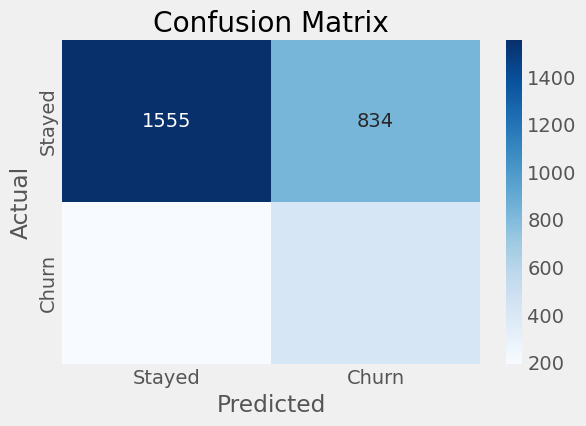

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed','Churn'], yticklabels=['Stayed','Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


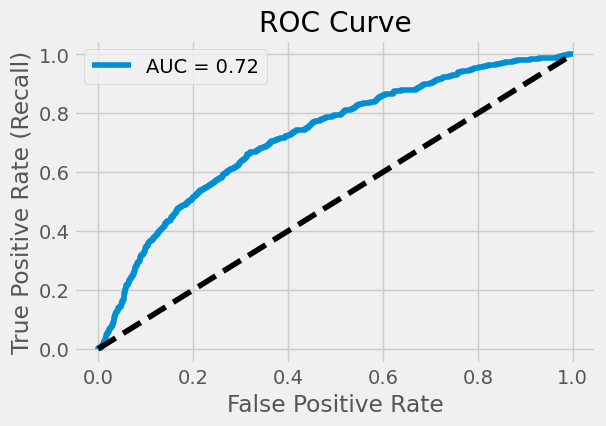

In [77]:
from sklearn.metrics import roc_curve, roc_auc_score

# get probabilities
y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# plot
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()


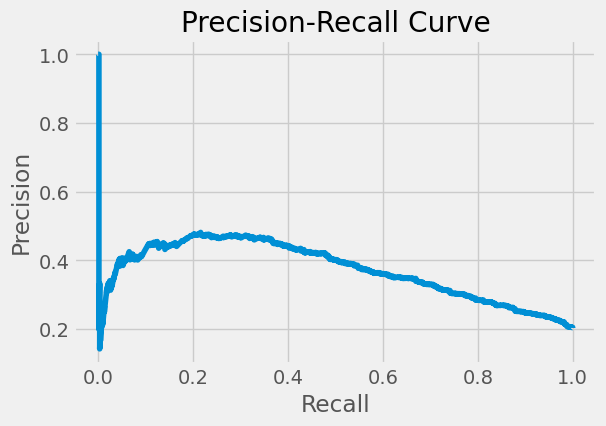

In [78]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [79]:

# Initialize the model
rf_clf = RandomForestClassifier(
    n_estimators=100,      # number of trees in the forest
    max_depth=None,        # let trees grow until leaves are pure
    random_state=42,       # reproducibility
    class_weight='balanced' # helps with imbalance (churn vs no churn)
)


Training the model

In [80]:
rf_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Predictions

In [81]:
y_pred_rf = rf_clf.predict(X_test)         # churn prediction (0/1).final prediction (stay = 0, churn = 1).
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]  # churn probability (0–1).probability the customer will churn (e.g., 0.73 = 73% chance).


In [82]:


# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):\n", cm_rf)

# Metrics
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))


Confusion Matrix (Random Forest):
 [[2314   75]
 [ 339  272]]

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.78      0.45      0.57       611

    accuracy                           0.86      3000
   macro avg       0.83      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



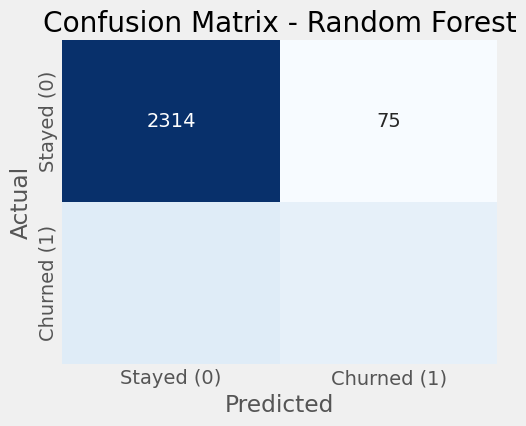

In [83]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Stayed (0)", "Churned (1)"],
            yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

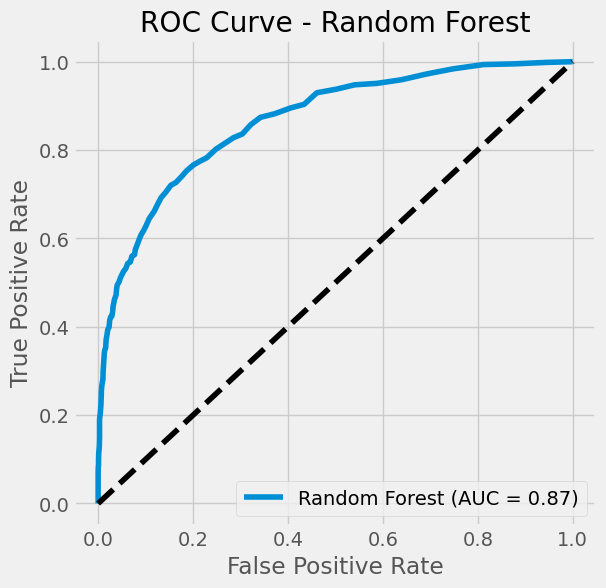

In [84]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


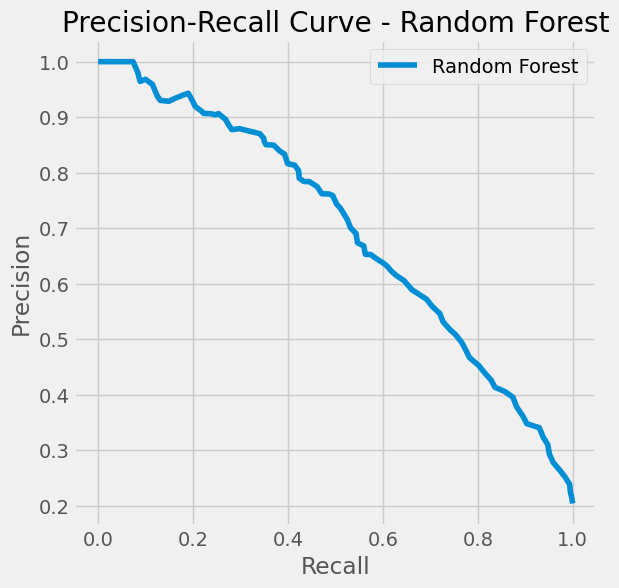

In [85]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()


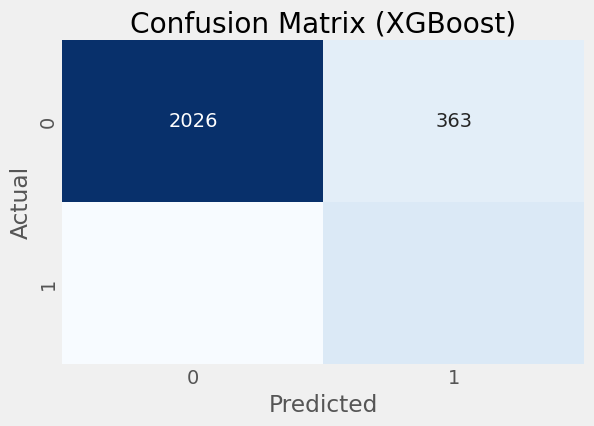

Confusion Matrix (XGBoost):
 [[2026  363]
 [ 172  439]]
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2389
           1       0.55      0.72      0.62       611

    accuracy                           0.82      3000
   macro avg       0.73      0.78      0.75      3000
weighted avg       0.85      0.82      0.83      3000



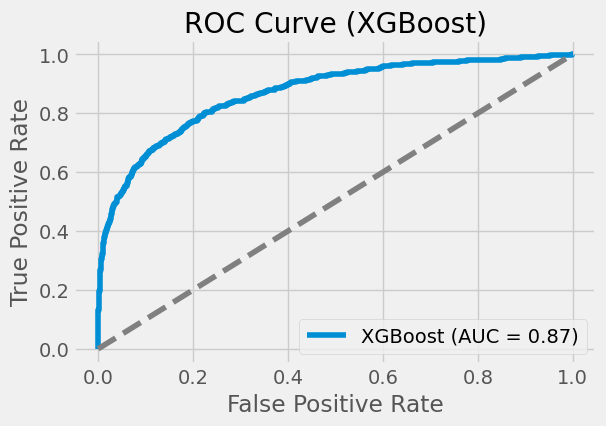

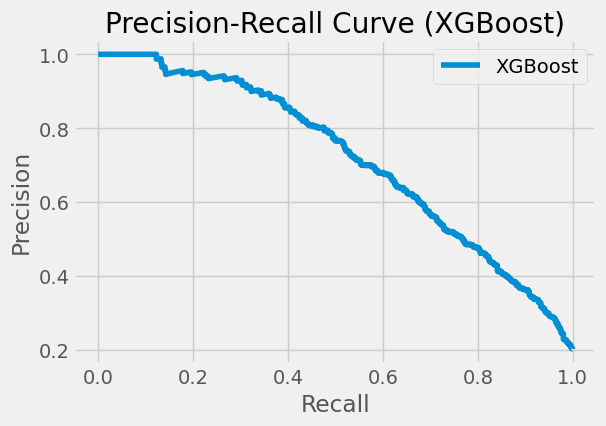

In [87]:


#Defining the model
# scale_pos_weight balances churners vs non-churners
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

#Trainning the model
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Confusion Matrix (XGBoost):\n", cm_xgb)

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Step 5: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.show()

# Step 6: Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.legend()
plt.show()
